In [1]:
import pandas as pd
import numpy as np
from datastreamer import DataStreamerP2V
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Load Data

In [2]:
baskets = pd.read_parquet("baskets.parquet")
coupons = pd.read_parquet("coupons.parquet")

In [3]:
baskets.head()

,week,shopper,product,price
0,0,0,71,629
1,0,0,91,605
2,0,0,116,715
3,0,0,123,483
4,0,0,157,592


In [4]:
coupons.head()

,week,shopper,product,discount
0,0,0,35,35
1,0,0,193,40
2,0,0,27,30
3,0,0,177,35
4,0,0,5,30


In [ ]:
print(f"Shopper Count: {baskets['shopper'].nunique()}")
print(f"Product Count: {baskets['product'].nunique()}")

## Specific Shopper History

In [6]:
# shopper_id = random.randrange(0, 10000)
# shopper_id
shopper_id = [random.randrange(0, 10000) for _ in range(100)]

In [10]:
basket_hist = baskets[baskets.shopper.isin(shopper_id)]
basket_hist

,week,shopper,product,price
609,0,82,21,463
610,0,82,76,582
611,0,82,118,750
612,0,82,127,619
613,0,82,182,656
...,...,...,...,...
68152171,89,9852,142,551
68152172,89,9852,156,575
68152173,89,9852,168,588
68152174,89,9852,199,604


In [11]:
coupon_hist = coupons[coupons.shopper.isin(shopper_id)]
coupon_hist

,week,shopper,product,discount
410,0,82,77,35
411,0,82,115,35
412,0,82,58,10
413,0,82,205,35
414,0,82,160,35
...,...,...,...,...
44549260,89,9852,81,10
44549261,89,9852,23,35
44549262,89,9852,144,40
44549263,89,9852,40,30


In [12]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [13]:
coupon_hist['product'].value_counts()

53     221
146    215
50     214
123    211
139    211
      ... 
63     155
142    155
38     155
202    153
240    152
Name: product, Length: 250, dtype: int64

In [14]:
coupon_hist['discount'].describe()

count   44550.0000
mean       25.1094
std        10.0178
min        10.0000
25%        15.0000
50%        25.0000
75%        35.0000
max        40.0000
Name: discount, dtype: float64

In [15]:
basket_hist['product'].value_counts()

105    1194
76     1062
199     981
40      857
196     752
       ... 
150      52
109      51
27       42
70       40
233      29
Name: product, Length: 250, dtype: int64

In [16]:
basket_hist['price'].describe()

count   66729.0000
mean      584.0459
std        97.8763
min       234.0000
25%       506.0000
50%       579.0000
75%       654.0000
max       837.0000
Name: price, dtype: float64

## Combining basket and coupon

In [17]:
full_df = (basket_hist
           .merge(
               coupon_hist, 
               on=['week', 'shopper', 'product'], 
               how='outer',
               indicator=True
           )
           .sort_values(by=['week', 'shopper', 'product'])
           .reset_index(drop=True)
           .replace(['left_only', 'right_only', 'both'], ['RRP', 'coupon', 'discounted'])
           .rename(columns={'_merge': 'status'})
          )

full_df.loc[full_df['discount'].isna(),'discount' ]=0

In [21]:
full_df

,week,shopper,product,price,discount,status
0,0,82,21,463.0000,0.0000,RRP
1,0,82,58,NaN,10.0000,coupon
2,0,82,76,582.0000,0.0000,RRP
3,0,82,77,NaN,35.0000,coupon
4,0,82,115,NaN,35.0000,coupon
...,...,...,...,...,...,...
108619,89,9852,144,NaN,40.0000,coupon
108620,89,9852,156,575.0000,0.0000,RRP
108621,89,9852,168,588.0000,0.0000,RRP
108622,89,9852,199,604.0000,0.0000,RRP


In [22]:
full_df.loc[full_df['product']==7]

,week,shopper,product,price,discount,status
27,0,159,7,NaN,40.0000,coupon
71,0,296,7,NaN,10.0000,coupon
158,0,876,7,772.0000,0.0000,RRP
448,0,3461,7,NaN,10.0000,coupon
1156,0,9504,7,NaN,20.0000,coupon
...,...,...,...,...,...,...
107437,89,115,7,772.0000,0.0000,RRP
107676,89,1489,7,502.0000,35.0000,discounted
107893,89,3799,7,NaN,15.0000,coupon
108157,89,6390,7,772.0000,0.0000,RRP


# EDA

<AxesSubplot:xlabel='product', ylabel='count'>

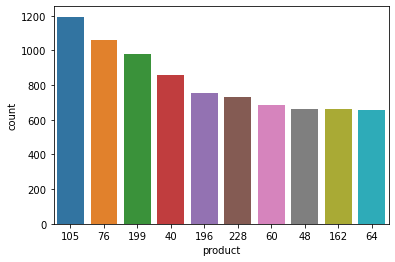

In [23]:
#plt.figure(figsize=(20,10))
sns.countplot(
    data=basket_hist, 
    x='product',
    order=basket_hist['product'].value_counts().iloc[:10].index
)

<AxesSubplot:xlabel='product', ylabel='count'>

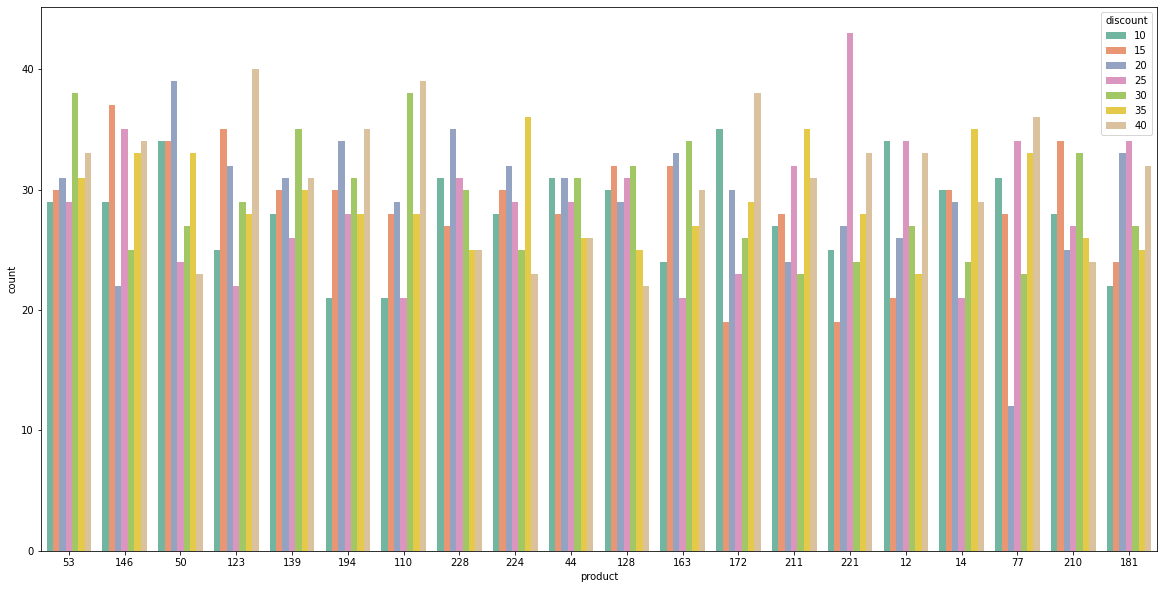

In [24]:
plt.figure(figsize=(20,10))
sns.countplot(
    data=coupon_hist, 
    x='product',
    hue='discount',
    order=coupon_hist['product'].value_counts().iloc[:20].index,
    palette="Set2"
)

<AxesSubplot:xlabel='product', ylabel='count'>

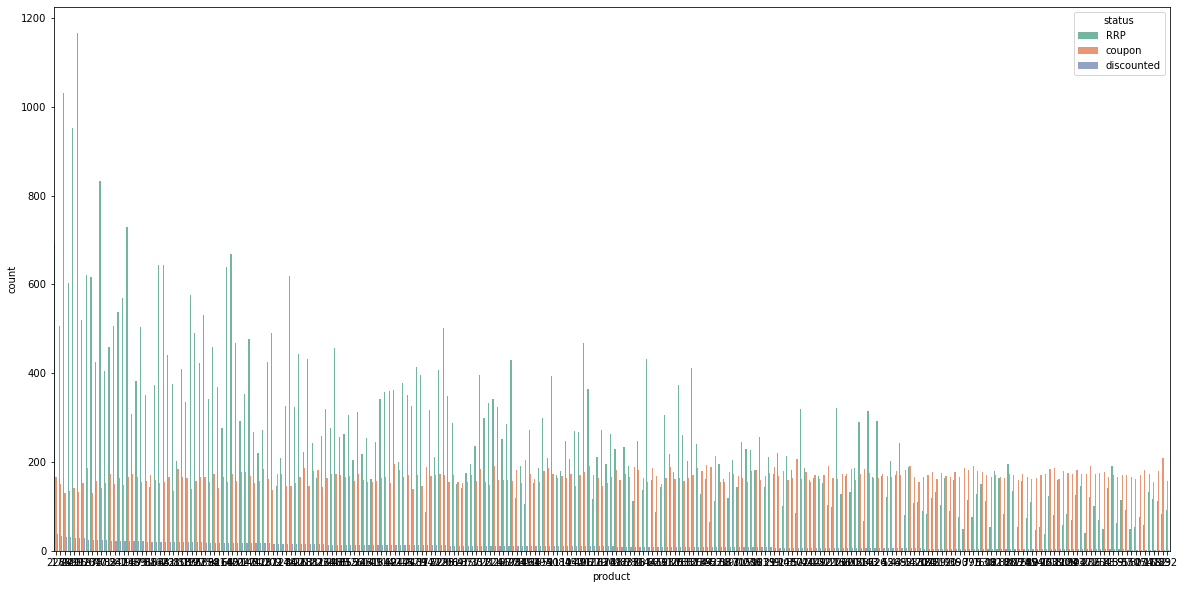

In [25]:
plt.figure(figsize=(20,10))
sns.countplot(
    data=full_df, 
    x='product',
    hue='status',
    #order=full_df['product'].value_counts().iloc[:2].index,
    order=pd.DataFrame(full_df.loc[full_df['status']=='discounted']['product'].value_counts()).index,
    palette="Set2"
)
# check prices

In [26]:
full_df.loc[full_df['status']=='discounted']['product'].value_counts()

228    37
171    34
76     32
249    31
199    29
       ..
17      1
169     1
182     1
139     1
232     1
Name: product, Length: 247, dtype: int64

<AxesSubplot:xlabel='status', ylabel='count'>

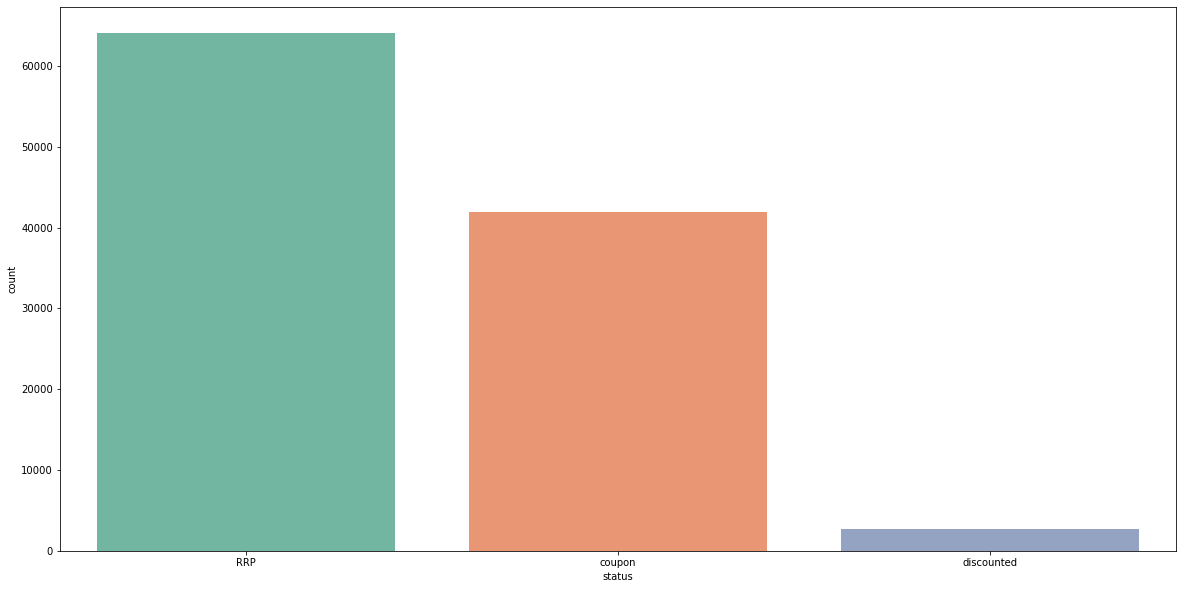

In [27]:
plt.figure(figsize=(20,10))
sns.countplot(
    data=full_df, 
    x='status',
    palette="Set2"
)

<AxesSubplot:xlabel='week', ylabel='product'>

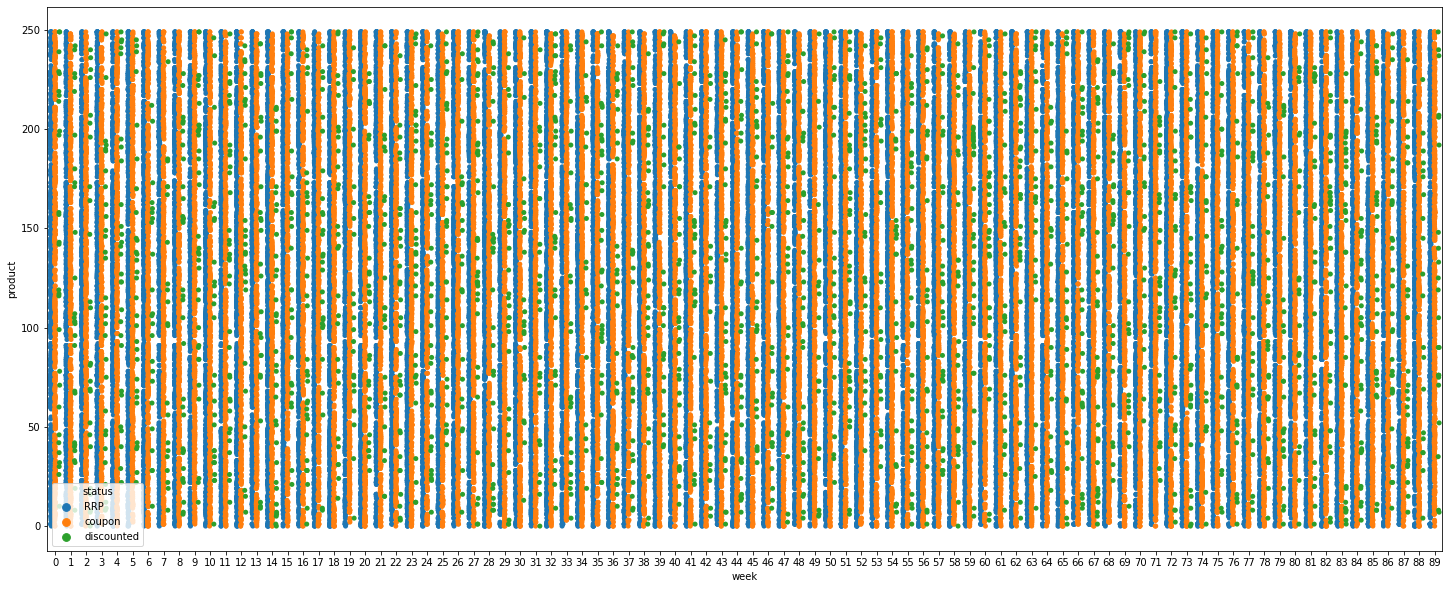

In [28]:
plt.figure(figsize=(25,10))
sns.stripplot(
    data=full_df, 
    x='week',
    y='product',
    hue='status',
    dodge=True
)